# EAS 587 - Project Phase 1: EDA of the Reddit Political Ecosystem

**Objective:** To perform an initial exploratory data analysis (EDA) on a dataset of posts and comments from seven politically-focused subreddits.

**Goals for this EDA:**
1.  Understand the volume and distribution of data across the selected subreddits.
2.  Analyze user activity patterns (e.g., posting times).
3.  Investigate the types of content being shared (text vs. links) and the primary information sources (domains).
4.  Examine community engagement and controversiality metrics.
5.  Identify key users and, most importantly, analyze the overlap of userbases between subreddits to find evidence of an "ecosystem."

**Subreddits in Ecosystem:**
- **Ideological Poles:** `r/Conservative`, `r/socialism`
- **Broader Political:** `r/politics` (Left-leaning), `r/Libertarian`
- **Neutral/Discussion-Focused:** `r/neutralnews`, `r/PoliticalDiscussion`
- **Battleground:** `r/worldnews`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Configuration
DATA_DIR = Path('data_cleaned')

print("Setup Complete. Libraries loaded and configuration set.")

Setup Complete. Libraries loaded and configuration set.


In [2]:
# Load all post and comment CSVs into two main dataframes

post_files = list(DATA_DIR.glob('*_posts.csv'))
comment_files = list(DATA_DIR.glob('*_comments.csv'))

# Load and concatenate posts
post_dfs = [pd.read_csv(f) for f in post_files]
all_posts_df = pd.concat(post_dfs, ignore_index=True)

# Load and concatenate comments
comment_dfs = [pd.read_csv(f) for f in comment_files]
all_comments_df = pd.concat(comment_dfs, ignore_index=True)

print("--- Posts Data ---")
print(f"Shape: {all_posts_df.shape}")
print(f"Subreddits: {all_posts_df['subreddit'].nunique()}")
print(all_posts_df.info())

print("\n--- Comments Data ---")
print(f"Shape: {all_comments_df.shape}")
print(f"Subreddits: {all_comments_df['subreddit'].nunique()}")
print(all_comments_df.info())

--- Posts Data ---
Shape: (32233, 15)
Subreddits: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32233 entries, 0 to 32232
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            32233 non-null  object 
 1   subreddit     32233 non-null  object 
 2   created_utc   32233 non-null  int64  
 3   title         32233 non-null  object 
 4   selftext      11379 non-null  object 
 5   url           31607 non-null  object 
 6   domain        31557 non-null  object 
 7   is_self       32233 non-null  bool   
 8   score         32233 non-null  int64  
 9   num_comments  32233 non-null  int64  
 10  upvote_ratio  32233 non-null  float64
 11  author        32233 non-null  object 
 12  stickied      32233 non-null  bool   
 13  over_18       32233 non-null  bool   
 14  permalink     32233 non-null  object 
dtypes: bool(3), float64(1), int64(3), object(8)
memory usage: 3.0+ MB
None

--- Comments Data ---
Shape: (1

### 1. Data Volume Analysis: How much activity is in each subreddit?

First, let's understand the scale of our data. A simple count of posts and comments per subreddit will show us which communities are most active and whether our data collection is balanced.

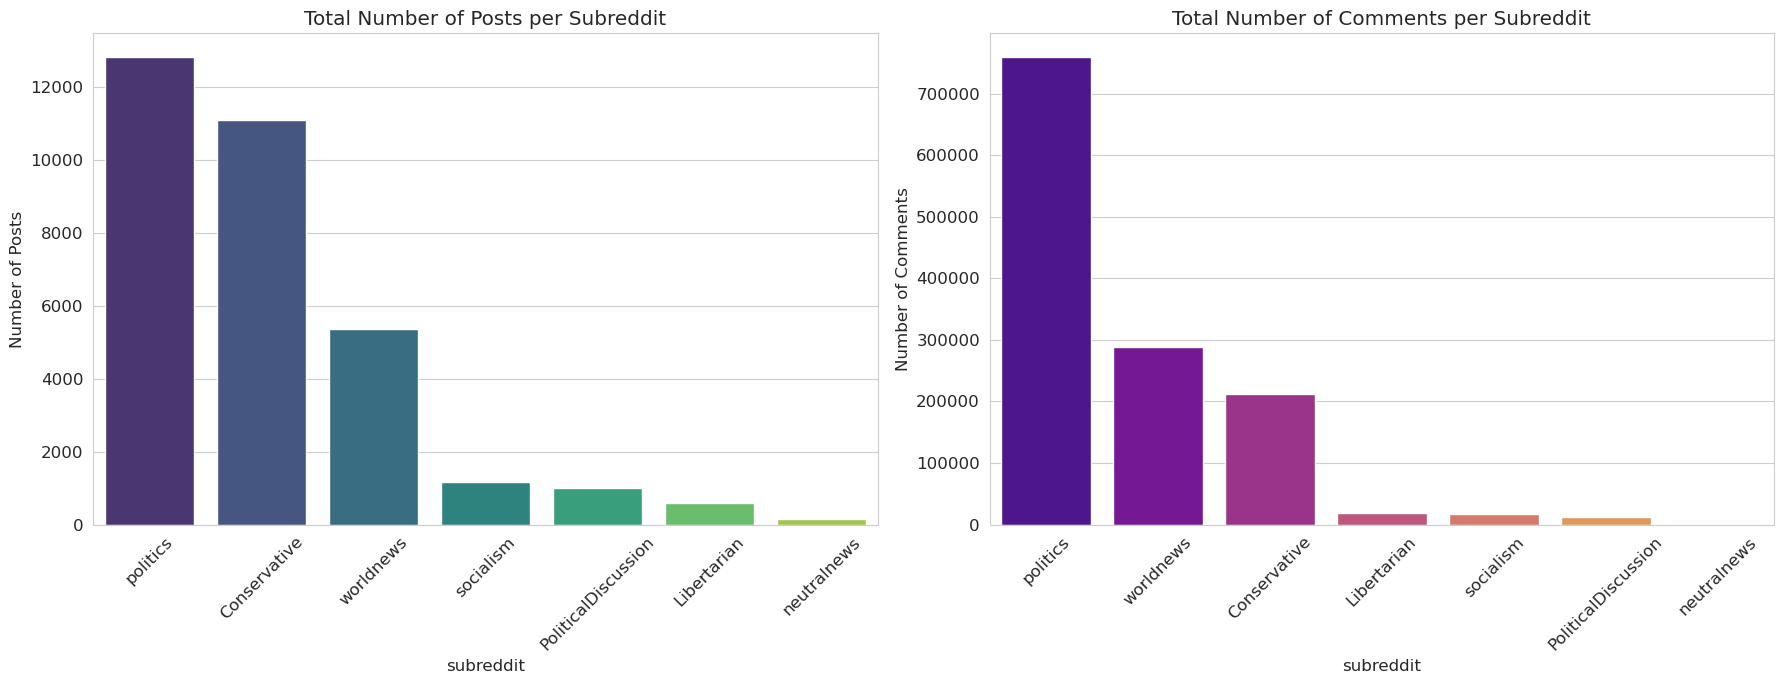

Comment Counts:
 subreddit
politics               760134
worldnews              288368
Conservative           211506
Libertarian             18102
socialism               17900
PoliticalDiscussion     12306
neutralnews               750
Name: count, dtype: int64


In [3]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot post counts
post_counts = all_posts_df['subreddit'].value_counts()
sns.barplot(x=post_counts.index, y=post_counts.values, hue=post_counts.index, 
            ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Total Number of Posts per Subreddit')
axes[0].set_ylabel('Number of Posts')
axes[0].tick_params(axis='x', rotation=45)

# Plot comment counts
comment_counts = all_comments_df['subreddit'].value_counts()
sns.barplot(x=comment_counts.index, y=comment_counts.values, hue=comment_counts.index,
            ax=axes[1], palette='plasma', legend=False)
axes[1].set_title('Total Number of Comments per Subreddit')
axes[1].set_ylabel('Number of Comments')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Comment Counts:\n", comment_counts)


### 2. Temporal Analysis: When are users most active?

By converting the `created_utc` timestamp, we can analyze activity by hour of the day. This can reveal patterns about the userbases (e.g., are they primarily from a specific time zone?).

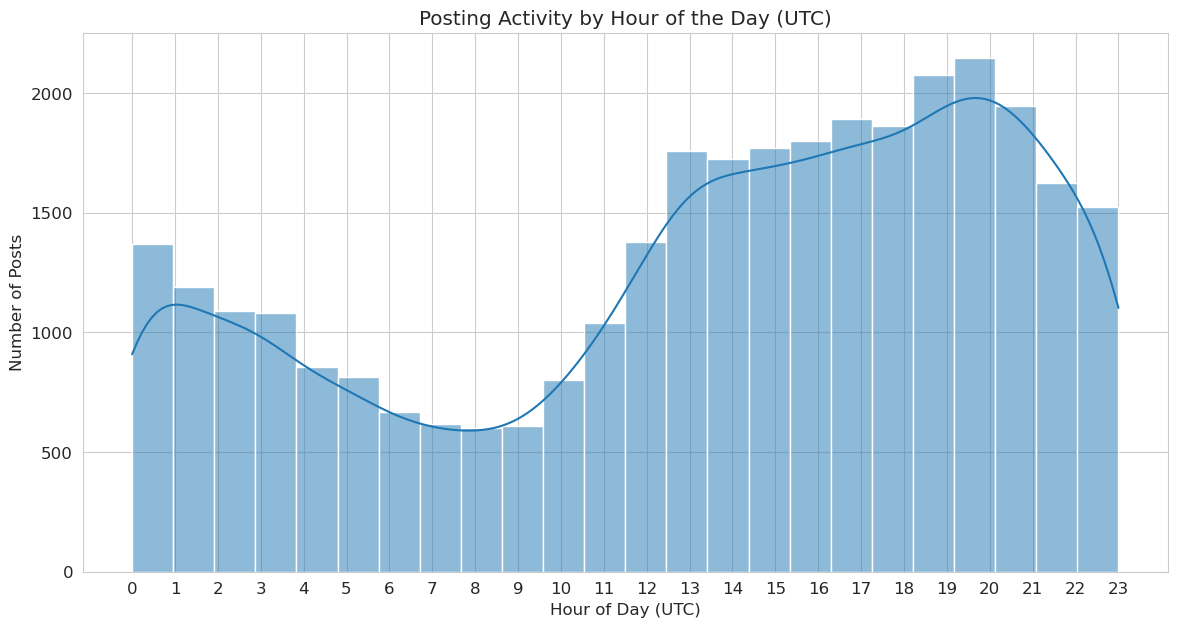

In [4]:
# Convert UTC timestamp to datetime objects
all_posts_df['created_datetime'] = pd.to_datetime(all_posts_df['created_utc'], unit='s')
all_comments_df['created_datetime'] = pd.to_datetime(all_comments_df['created_utc'], unit='s')

# Extract hour
all_posts_df['hour'] = all_posts_df['created_datetime'].dt.hour

# Plot activity by hour
plt.figure(figsize=(14, 7))
sns.histplot(data=all_posts_df, x='hour', bins=24, kde=True)
plt.title('Posting Activity by Hour of the Day (UTC)')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Number of Posts')
plt.xticks(range(24))
plt.show()

### 3. Content Analysis: What kind of content is shared?

We can separate posts into two types:
- **Text Posts (`is_self` = True):** Internal discussions, questions, and community-generated content.
- **Link Posts (`is_self` = False):** Sharing of external articles, images, or videos.

The ratio of text-to-link posts can indicate whether a community is more focused on internal conversation or on reacting to external information.

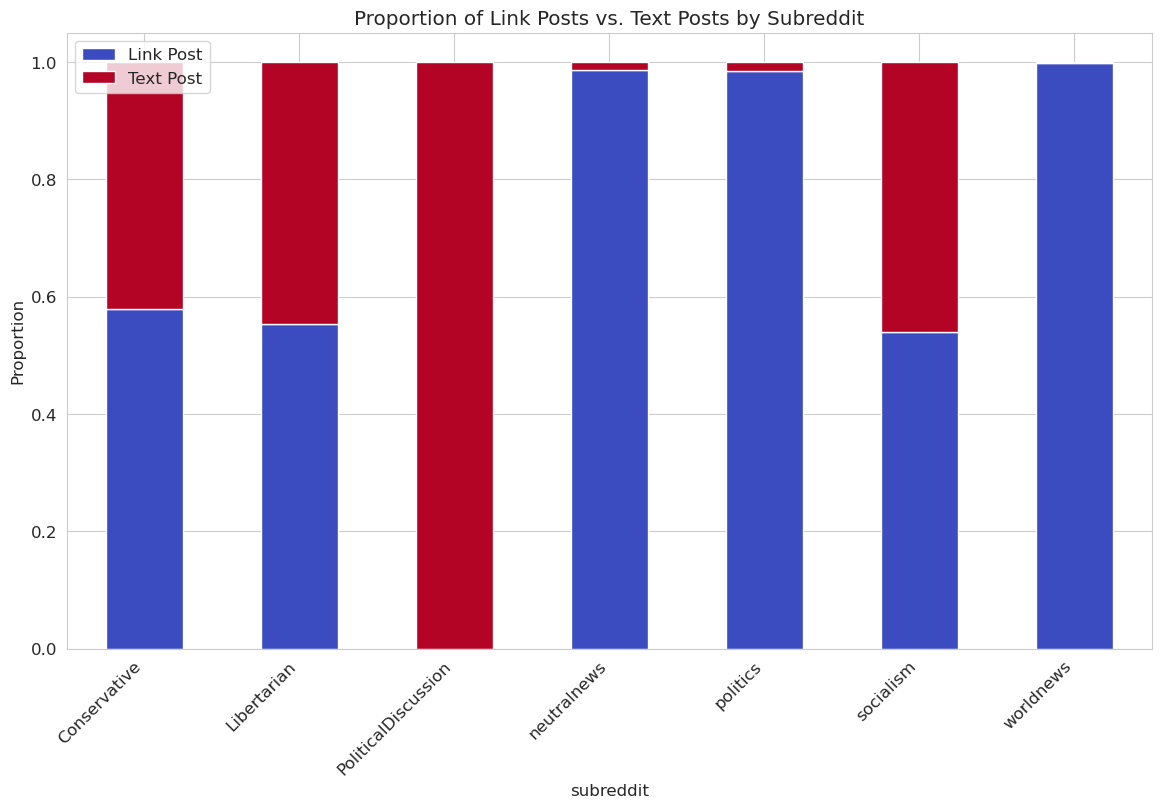

In [5]:
# Calculate percentage of self (text) posts vs link posts
post_type_dist = all_posts_df.groupby('subreddit')['is_self'].value_counts(normalize=True).unstack()
post_type_dist.columns = ['Link Post', 'Text Post']

# Plotting
post_type_dist.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='coolwarm',
    title='Proportion of Link Posts vs. Text Posts by Subreddit'
)
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.show()

### 4. Source Analysis: Where does the information come from?

For link posts, the `domain` is a critical feature. Analyzing the most frequently posted domains in each subreddit is a direct way to uncover media bias and potential echo chambers. We expect to see highly polarized source preferences.

In [6]:
# Filter for link posts only
link_posts_df = all_posts_df[all_posts_df['is_self'] == False].copy()

# Get top 10 domains for each subreddit
top_domains = {}
for subreddit in link_posts_df['subreddit'].unique():
    # Filter out common image/video hosts to focus on news/information sources
    filtered_domains = link_posts_df[
        (link_posts_df['subreddit'] == subreddit) &
        (~link_posts_df['domain'].isin(['i.redd.it', 'v.redd.it', 'youtube.com', 'youtu.be', 'imgur.com']))
    ]
    top_domains[subreddit] = filtered_domains['domain'].value_counts().head(10)

# Print the results
for subreddit, domains in top_domains.items():
    print(f"\n--- Top 10 Information Domains for r/{subreddit} ---")
    print(domains)


--- Top 10 Information Domains for r/Conservative ---
domain
foxnews.com          377
reddit.com           364
x.com                322
nypost.com           303
breitbart.com        170
thefederalist.com     82
newsmax.com           66
wsj.com               55
townhall.com          55
babylonbee.com        42
Name: count, dtype: int64

--- Top 10 Information Domains for r/Libertarian ---
domain
reddit.com                  12
mises.org                    8
libertarianinstitute.org     6
news.antiwar.com             6
x.com                        5
tiktok.com                   4
lewrockwell.com              4
cnn.com                      4
politico.com                 3
newrepublic.com              3
Name: count, dtype: int64

--- Top 10 Information Domains for r/neutralnews ---
domain
reuters.com        64
apnews.com         40
newrepublic.com     6
nytimes.com         4
nbcnews.com         4
cnn.com             3
theguardian.com     2
npr.org             2
usatoday.com        2
bbc.co

### 5. User Engagement Analysis (Score vs. Comments)
A key question is how different communities engage with content. Does a high score always correlate with many comments? A scatter plot can reveal different engagement patterns. We'll plot this on a log-log scale to handle the wide distribution.

Available rows after filtering: 19,023
Using sample size: 19,023


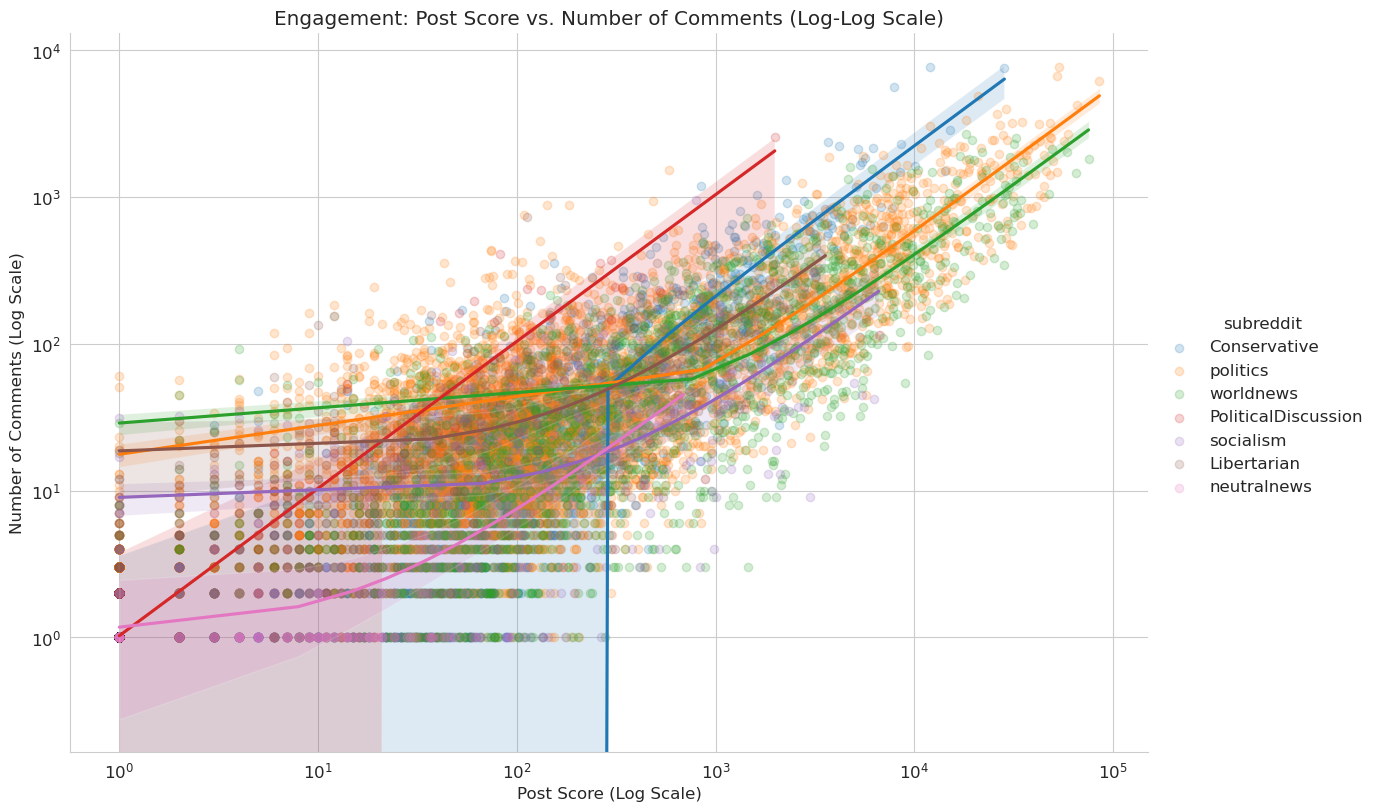

In [7]:
# Filter out posts with 0 or negative scores for log plot
filtered_df = all_posts_df[(all_posts_df['score'] > 0) & (all_posts_df['num_comments'] > 0)]

# Check how many rows we have and adjust sample size accordingly
available_rows = len(filtered_df)
sample_size = min(50000, available_rows)  # Use smaller of 50k or available rows

print(f"Available rows after filtering: {available_rows:,}")
print(f"Using sample size: {sample_size:,}")

sample_df = filtered_df.sample(n=sample_size, random_state=1)

g = sns.lmplot(
    data=sample_df,
    x='score', y='num_comments',
    hue='subreddit',
    height=8,
    aspect=1.5,
    scatter_kws={'alpha':0.2}
)
g.ax.set_xscale('log')
g.ax.set_yscale('log')
plt.title('Engagement: Post Score vs. Number of Comments (Log-Log Scale)')
plt.xlabel('Post Score (Log Scale)')
plt.ylabel('Number of Comments (Log Scale)')
plt.show()


### 6. Engagement Analysis: What resonates with each community?

We can measure engagement using `score` and `num_comments`. By comparing the distribution of scores across subreddits, we can see which communities generate more highly-rated content. We'll use a log scale for the y-axis to handle the large range of scores.

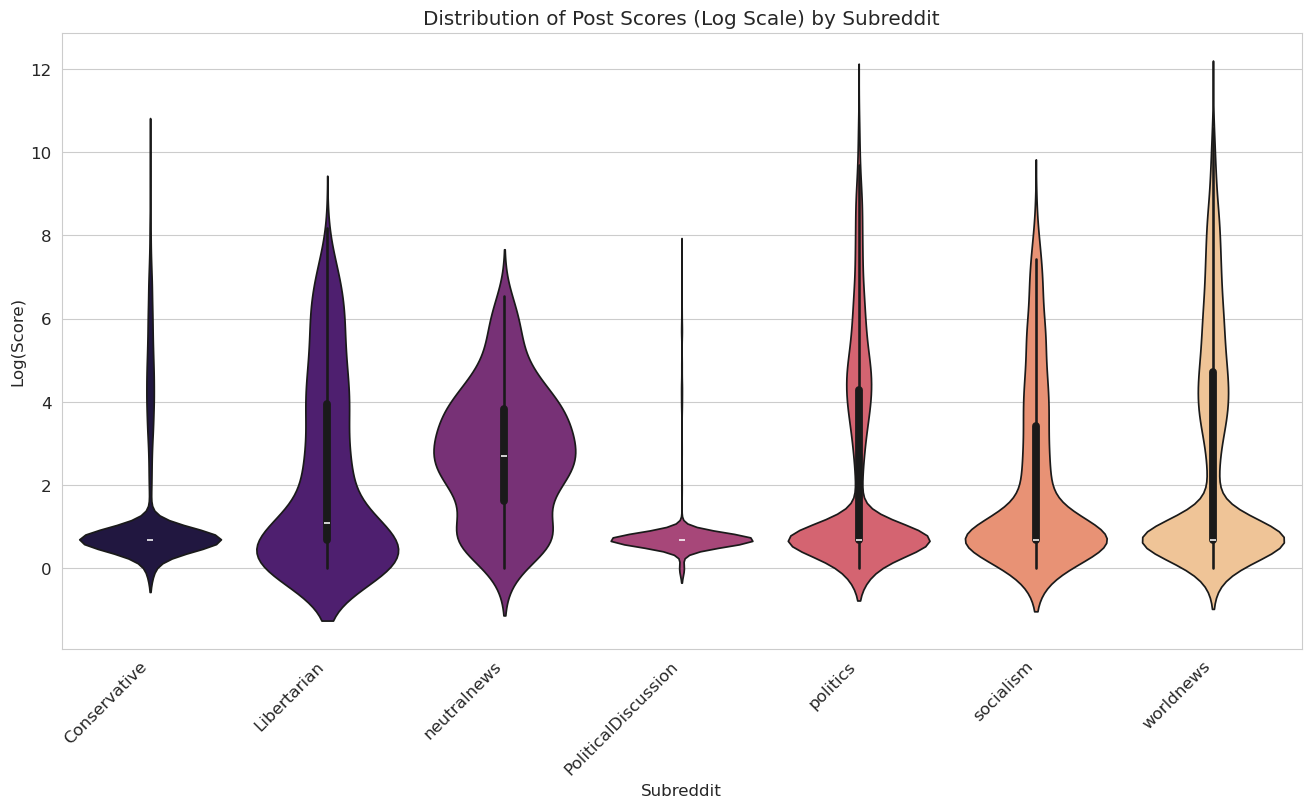

In [8]:
# Add a small constant to score to avoid log(0) or log(negative) issues
all_posts_df['score_log'] = np.log(all_posts_df['score'] + 1 - all_posts_df['score'].min())

plt.figure(figsize=(16, 8))
sns.violinplot(data=all_posts_df, x='subreddit', y='score_log', hue='subreddit', palette='magma', legend=False)
plt.title('Distribution of Post Scores (Log Scale) by Subreddit')
plt.ylabel('Log(Score)')
plt.xlabel('Subreddit')
plt.xticks(rotation=45, ha='right')
plt.show()


### 7. Controversiality Analysis

Reddit's `upvote_ratio` for posts and `controversiality` flag for comments are direct indicators of polarizing content.
- An **upvote ratio** near 0.5 means a post received a similar number of upvotes and downvotes.
- A **controversial comment** is one with a large number of both upvotes and downvotes.

This analysis helps us pinpoint which communities foster more divisive discussions.

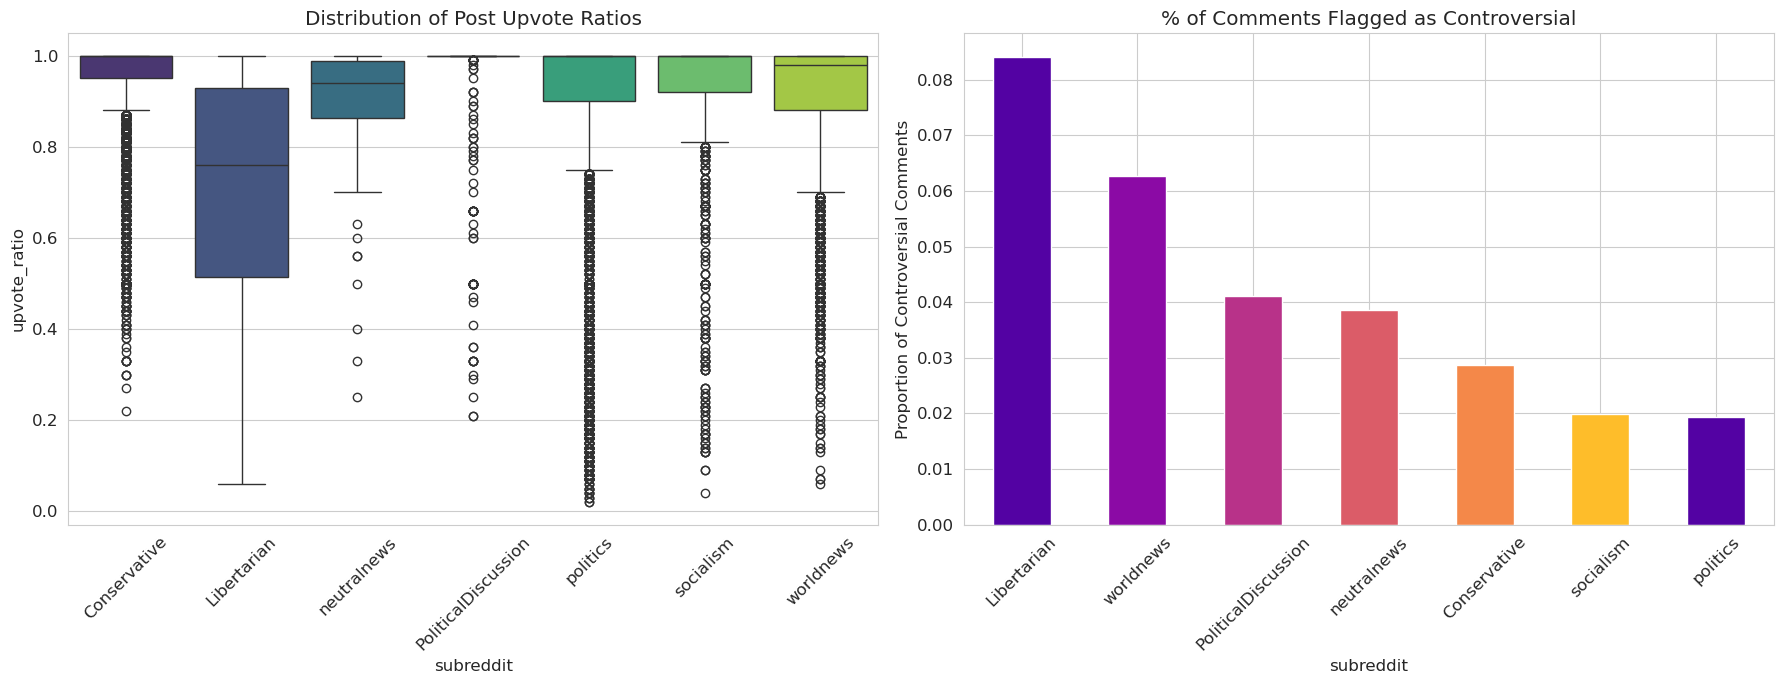

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot upvote ratio for posts
sns.boxplot(data=all_posts_df, x='subreddit', y='upvote_ratio', hue='subreddit', 
            ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Distribution of Post Upvote Ratios')
axes[0].tick_params(axis='x', rotation=45)

# Calculate and plot percentage of controversial comments
controversial_comments = all_comments_df.groupby('subreddit')['controversiality'].value_counts(normalize=True).unstack()
controversial_comments.columns = ['Not Controversial', 'Controversial']
controversial_comments['Controversial'].sort_values(ascending=False).plot(
    kind='bar',
    ax=axes[1],
    color=sns.color_palette('plasma'),
    title='% of Comments Flagged as Controversial'
)
axes[1].set_ylabel('Proportion of Controversial Comments')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 8. User Analysis: Who are the most active users?

Identifying the most active authors is the first step toward finding influential users. We will filter out `[deleted]` users, as they are anonymous.

In [10]:
# Filter out deleted users AND bots
bot_accounts = ['AutoModerator', 'politics-ModTeam']  # Add other known bots
valid_authors_posts = all_posts_df[
    (~all_posts_df['author'].isin(['[deleted]'] + bot_accounts))
]
valid_authors_comments = all_comments_df[
    (~all_comments_df['author'].isin(['[deleted]'] + bot_accounts))
]

# Top 10 posters
top_posters = valid_authors_posts['author'].value_counts().head(10)
print("--- Top 10 Human Posters Across All Subreddits ---")
print(top_posters)

# Top 10 commenters
top_commenters = valid_authors_comments['author'].value_counts().head(10)
print("\n--- Top 10 Human Commenters Across All Subreddits ---")
print(top_commenters)

# Show bot statistics separately (optional)
bot_comments = all_comments_df[all_comments_df['author'].isin(bot_accounts)]['author'].value_counts()
print(f"\n--- Bot Activity (Excluded from Analysis) ---")
print(bot_comments)


--- Top 10 Human Posters Across All Subreddits ---
author
According-Activity87    429
Ask4MD                  278
hety0p                  277
NewSlinger              239
swan8895                130
WillyNilly1997          115
ChaskaChanhassen        110
Down-not-out            103
NeutralverseBot          96
Murky-Site7468           94
Name: count, dtype: int64

--- Top 10 Human Commenters Across All Subreddits ---
author
TintedApostle           2436
mightcommentsometime    1016
stroopwafelscontigo      814
Umami-Ice-Cream          793
ToNoMoCo                 768
thistimelineisweird      744
jediporcupine            742
faffc260                 700
Maaster_Mind             695
ShamelessCatDude         666
Name: count, dtype: int64

--- Bot Activity (Excluded from Analysis) ---
author
AutoModerator       18880
politics-ModTeam     1667
Name: count, dtype: int64


### 9. Cross-Subreddit Analysis: The User Overlap Matrix

This is the most critical part of our EDA for the echo chamber analysis. We will build a matrix to see what percentage of users from one subreddit also participate in another.

A high degree of overlap between two ideologically similar subreddits (e.g., `r/politics` and `r/socialism`) and a very low overlap between dissimilar ones (e.g., `r/Conservative` and `r/socialism`) would provide strong evidence for our "ecosystem" hypothesis.

The heatmap below shows: For each pair of subreddits (A, B), what percentage of users from subreddit A also post or comment in subreddit B?

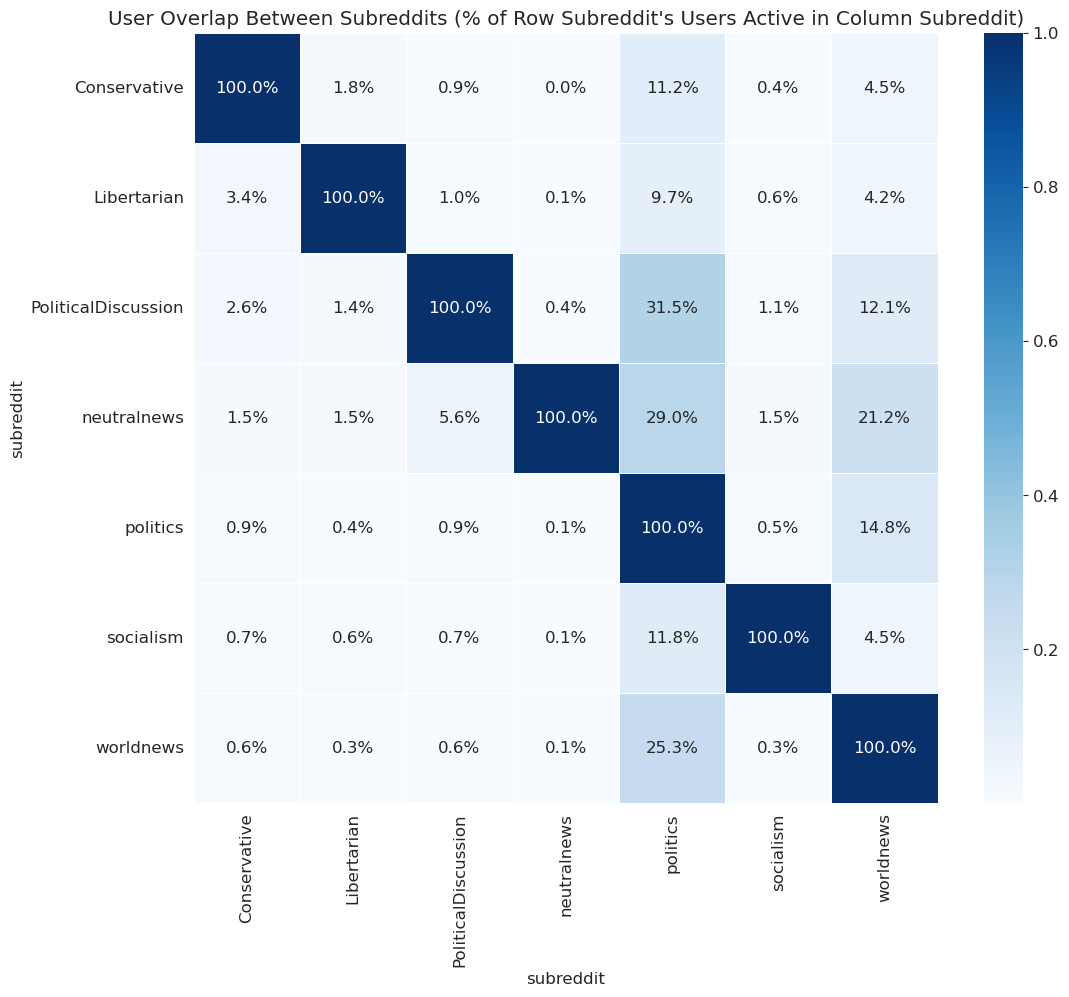

In [11]:
# We only need author and subreddit columns
user_subreddit_pairs = pd.concat([
    all_posts_df[['author', 'subreddit']],
    all_comments_df[['author', 'subreddit']]
]).drop_duplicates()

# Filter out deleted user
user_subreddit_pairs = user_subreddit_pairs[user_subreddit_pairs['author'] != '[deleted]']

# Create a crosstab: authors as rows, subreddits as columns
crosstab = pd.crosstab(user_subreddit_pairs['author'], user_subreddit_pairs['subreddit'])

# Convert to binary (1 if user participated, 0 otherwise)
crosstab_binary = (crosstab > 0).astype(int)

# Calculate the overlap matrix (dot product)
# This gives us a subreddit x subreddit matrix where each cell (i, j) is the number of users active in both.
overlap_matrix = crosstab_binary.T.dot(crosstab_binary)

# Normalize the matrix to get percentages
# overlap_matrix.loc[i, j] / overlap_matrix.loc[i, i] gives % of users from sub 'i' that are also in sub 'j'
overlap_percentage = overlap_matrix.div(np.diag(overlap_matrix), axis=0)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    overlap_percentage,
    annot=True,
    fmt=".1%",
    cmap='Blues',
    linewidths=.5
)
plt.title('User Overlap Between Subreddits (% of Row Subreddit\'s Users Active in Column Subreddit)')
plt.show()

### 10: Text Content Preview (Comment Length)
As a preliminary step for our future NLP analysis, let's examine the distribution of comment lengths. Are discussions in some subreddits more verbose than others? This can provide insight into the nature of the discourse.

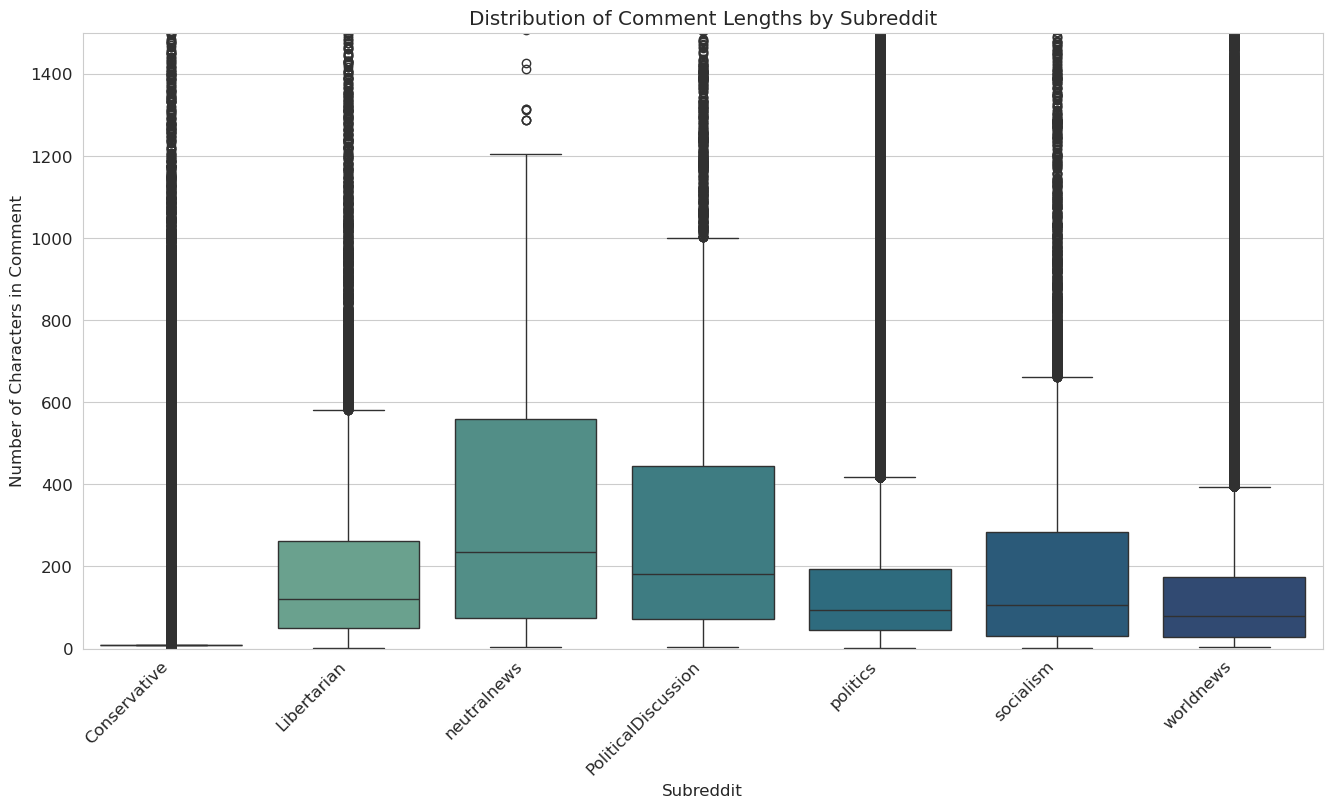

In [12]:
# Calculate comment length
all_comments_df['comment_length'] = all_comments_df['body'].str.len()

# Plot the distribution of comment lengths (on a log scale for x-axis)
plt.figure(figsize=(16, 8))
sns.boxplot(data=all_comments_df, x='subreddit', y='comment_length', hue='subreddit', 
            palette='crest', legend=False)
plt.title('Distribution of Comment Lengths by Subreddit')
plt.ylabel('Number of Characters in Comment')
plt.xlabel('Subreddit')
plt.ylim(0, 1500)  # Zoom in to a reasonable range to see the boxplots
plt.xticks(rotation=45, ha='right')
plt.show()


### EDA Conclusion & Next Steps

This initial EDA has provided several key insights that strongly support our project's premise:

1.  **Clear Source Polarization:** The `Top Domain Analysis` (Step 4) shows starkly different information sources preferred by different subreddits, a classic indicator of echo chambers. For example, `r/Conservative` heavily favors right-leaning domains while `r/politics` favors left-leaning ones.
2.  **Ecosystem Structure is Visible:** The `User Overlap Matrix` (Step 9) is the most powerful finding. It visually confirms our hypothesis of an ideological ecosystem. We see strong "clusters" of users (e.g., high overlap between `r/politics` and `r/worldnews`) and clear "divides" (e.g., very low overlap between `r/Conservative` and `r/socialism`).
3.  **Varying Levels of Controversiality:** Subreddits like `r/politics` and `r/Conservative` show higher proportions of controversial comments, suggesting more contentious debate environments compared to a subreddit like `r/neutralnews`.

**Next Steps for the Project:**
- **Deeper NLP:** Move beyond simple counts to analyze the *language* used. We will perform sentiment analysis and topic modeling on post titles and comment bodies to quantify the difference in narrative framing between communities.
- **Network Analysis:** Model the user-subreddit relationships as a graph to formally identify clusters and influential "bridge" users who connect different communities.
- **Information Flow Tracking:** Trace specific URLs as they are posted across the ecosystem to see how the discussion (title, comments, score) changes in each community.